## LSTM 사용 Text 분류 모델 구현
: Keras의 Embedding,LSTM,Dropout 계층 사용

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

###  Spam and Ham 분류 테스트 데이터 셋 읽어오기

In [2]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
# ISO/IEC 8859-1, https://ko.wikipedia.org/wiki/ISO/IEC_8859-1
print(df.shape)  # (5572, 5)
print(df['v2'][0], df['v1'][0])  # ham
df.head(20)

(5572, 5)
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ham


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### 불필요한 컬럼 삭제

In [3]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
df.head(20)
# df.info()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

### 분포를 시각화

Text(0.5, 1.0, 'Number of ham and spam messages')

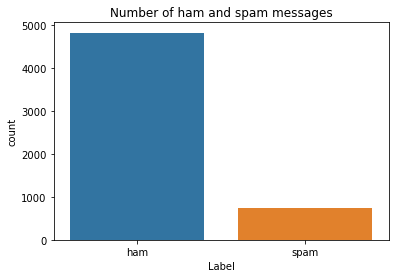

In [5]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

### Y 값을 0, 1로 변환 : LabelEncoder()


In [6]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)    # Y 값이 0,1로 변환, Logistic Regression, sigmoid사용
Y = Y.reshape(-1,1)
print(Y.shape)  

(5572, 1)


In [7]:
### train 과 test 데이터 셋으로 분리
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3) # 70:30
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(3900,) (1672,) (3900, 1) (1672, 1)


### 문장을 토큰화 처리, 패딩, 데이터셋의 길이를 설정

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

In [9]:
#토큰나이저를 시행하여 단어를 숫자값, 인덱스로 변환하여 저장

max_words = 1000
max_len = 150  # 데이터 셋의 길이


tok = Tokenizer(num_words=max_words) # 가장 빈도가 높은 1000 개의 단어들만 사용하여 토큰화

# 단어 인덱스를 구축
tok.fit_on_texts(X_train)  # 범위 : 0 ~ 999

# 문자열을 정수 인덱스의 리스트로 변환
sequences = tok.texts_to_sequences(X_train)
# sequences


# 벡터 표현을 얻음
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)   # 신경망에 입력할 X값이다
print(sequences_matrix.shape) # (3900, 150)
# sequences_matrix

word_to_index = tok.word_index
# print(word_to_index)
vocab_size = len(word_to_index)
print(vocab_size) # 7339

sequences_matrix

(3900, 150)
7413


array([[  0,   0,   0, ...,  24, 232, 241],
       [  0,   0,   0, ...,   6, 315,  50],
       [  0,   0,   0, ...,  68, 150, 186],
       ...,
       [  0,   0,   0, ...,  12, 279,  69],
       [  0,   0,   0, ..., 109,   7, 182],
       [  0,   0,   0, ...,   3, 315,  29]])

## RNN 신경망 모델 구현

In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

# tf.keras.layers.Embedding(
#     input_dim, output_dim, embeddings_initializer='uniform',
#     embeddings_regularizer=None, activity_regularizer=None,
#     embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
# )

# input_dim : input_dim   , D  , max_words : 1000
# output_dim : hidden_size , H , 50
# input_length : sequence_length , T : max_len:150

In [11]:
# # LSTM 1층을 사용하여 신경망을 구현  : Accuracy : 0.982
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(max_words,50,input_length=max_len), # 3차원으로 출력, (None, 150, 50)
#     tf.keras.layers.LSTM(32,return_sequences=True),  # 3차원으로 출력, (None, 150, 32) 
#     tf.keras.layers.Dense(32,activation='relu'),     # 3차원으로 출력, (None, 150, 32)
#     tf.keras.layers.Dropout(rate=0.5),               # 3차원으로 출력, (None, 150, 32)
#     tf.keras.layers.Flatten(),                       # 2차원으로 출력, (None, 4800)
#     tf.keras.layers.Dense(1,activation='sigmoid')    # 2차원으로 출력, (None, 1)
# ])

# model.summary()

In [12]:
# LSTM 2층 을 사용하여 신경망을 구현  :    [ Accuracy :  0.983]  # 2층의 정확도가 약간 높다
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words,50,input_length=max_len), # 3차원으로 출력, (None, 150, 50) 
    tf.keras.layers.LSTM(32,return_sequences=True),  # 3차원으로 출력, (None, 150, 32) 
    tf.keras.layers.LSTM(32),                        # 2차원으로 출력, (None,  32) 
    tf.keras.layers.Dense(32,activation='relu'),     # 2원으로 출력,   (None,  32)
    tf.keras.layers.Dropout(rate=0.5),               # 2차원으로 출력, (None,  32)
    # tf.keras.layers.Flatten(),                     
    tf.keras.layers.Dense(1,activation='sigmoid')    # 2차원으로 출력, (None, 1)
])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 150, 32)           10624     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
__________________

In [13]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# RMSProp : https://forensics.tistory.com/28
# RMSprop 알고리즘은 Adadelta와 마찬가지로 Adagrad에서 학습률이 급격하게 감소하는 문제를 해결 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# 학습
model.fit(sequences_matrix,Y_train,batch_size=128, epochs=10, validation_split=0.2)

Train on 3120 samples, validate on 780 samples
Epoch 1/10
3120/3120 [==============================] - 8s 3ms/sample - loss: 0.4729 - acc: 0.8301 - val_loss: 0.2609 - val_acc: 0.8808
Epoch 2/10
3120/3120 [==============================] - 7s 2ms/sample - loss: 0.2104 - acc: 0.9423 - val_loss: 0.1446 - val_acc: 0.9692
Epoch 3/10
3120/3120 [==============================] - 7s 2ms/sample - loss: 0.1040 - acc: 0.9798 - val_loss: 0.1084 - val_acc: 0.9692
Epoch 4/10
3120/3120 [==============================] - 7s 2ms/sample - loss: 0.0671 - acc: 0.9869 - val_loss: 0.1236 - val_acc: 0.9628
Epoch 5/10
3120/3120 [==============================] - 7s 2ms/sample - loss: 0.0483 - acc: 0.9897 - val_loss: 0.0781 - val_acc: 0.9756
Epoch 6/10
3120/3120 [==============================] - 7s 2ms/sample - loss: 0.0389 - acc: 0.9917 - val_loss: 0.0844 - val_acc: 0.9782
Epoch 7/10
3120/3120 [==============================] - 7s 2ms/sample - loss: 0.0281 - acc: 0.9926 - val_loss: 0.0943 - val_acc: 0.9782
E

### 정확도 측정

In [15]:
# Test 데이터세의 벡터를 구함

# 문자열을 정수 인덱스의 리스트로 변환
test_sequences = tok.texts_to_sequences(X_test)
# test_sequences

# 벡터 표현을 얻음
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)   
print(test_sequences_matrix.shape) # (1672, 150)
test_sequences_matrix


(1672, 150)


array([[  0,   0,   0, ...,  13,  19,   5],
       [  0,   0,   0, ...,  67,   8,   4],
       [  0,   0,   0, ..., 114,  15, 855],
       ...,
       [  0,   0,   0, ...,  78, 744, 145],
       [  0,   0,   0, ..., 388,  12,  15],
       [  0,   0,   0, ..., 217, 473, 133]])

In [16]:
# 정확도
accr = model.evaluate(test_sequences_matrix,Y_test)

1672/1672 [==============================] - 2s 1ms/sample - loss: 0.0848 - acc: 0.9856


In [17]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.085
  Accuracy: 0.986


In [18]:
# 예측
preds = model.predict(test_sequences_matrix[0].reshape(1,-1)) # test_sequences_matrix[0]은 1차원이므로
preds,Y_test[0]

(array([[0.00012975]], dtype=float32), array([0]))

In [19]:
test_sequences_matrix[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 34,  3, 60, 13, 19,  5])

In [24]:
preds = model.predict(test_sequences_matrix[17].reshape(1,-1)) # test_sequences_matrix[0]은 1차원이므로
preds,Y_test[17]

(array([[0.99970955]], dtype=float32), array([1]))

In [21]:
ones = np.where(Y_test==1)   # 답이 1인 인덱스
ones[0]

array([  17,   19,   25,   42,   80,   84,   86,   92,  110,  119,  122,
        123,  125,  130,  136,  146,  153,  165,  170,  171,  184,  193,
        203,  206,  208,  210,  211,  214,  217,  219,  229,  235,  237,
        240,  244,  247,  263,  272,  300,  318,  337,  351,  352,  361,
        362,  365,  368,  372,  381,  414,  418,  423,  426,  429,  432,
        449,  467,  475,  477,  482,  483,  487,  496,  498,  499,  507,
        509,  517,  538,  542,  547,  548,  558,  565,  566,  571,  578,
        588,  594,  598,  603,  613,  621,  625,  644,  665,  673,  674,
        682,  683,  695,  697,  703,  716,  719,  723,  725,  742,  758,
        771,  782,  790,  822,  828,  837,  842,  845,  847,  850,  851,
        852,  853,  864,  867,  888,  918,  927,  932,  934,  948,  954,
        959,  965,  967,  978,  989,  997, 1012, 1023, 1026, 1034, 1037,
       1052, 1069, 1073, 1074, 1079, 1084, 1090, 1091, 1092, 1098, 1101,
       1110, 1129, 1148, 1150, 1164, 1178, 1180, 11

In [27]:
for one in ones[0]:
    preds = model.predict(test_sequences_matrix[one].reshape(1,-1))
    print(preds,Y_test[one])

[[0.99970955]] [1]
[[0.9996898]] [1]
[[0.99971277]] [1]
[[0.9996784]] [1]
[[0.9945655]] [1]
[[0.99967563]] [1]
[[0.9996674]] [1]
[[0.9995708]] [1]
[[0.9982431]] [1]
[[0.99955565]] [1]
[[0.99966884]] [1]
[[0.999561]] [1]
[[0.9996879]] [1]
[[0.9982198]] [1]
[[8.317396e-05]] [1]
[[0.9995449]] [1]
[[0.9994542]] [1]
[[0.99968207]] [1]
[[0.9994892]] [1]
[[0.99971396]] [1]
[[0.9986753]] [1]
[[0.99938726]] [1]
[[0.9996427]] [1]
[[0.99965906]] [1]
[[0.99956733]] [1]
[[0.9995609]] [1]
[[0.99950886]] [1]
[[0.9994466]] [1]
[[0.99955815]] [1]
[[0.9995672]] [1]
[[0.99965763]] [1]
[[8.545548e-06]] [1]
[[0.9996252]] [1]
[[0.9996668]] [1]
[[0.9995734]] [1]
[[0.99889225]] [1]
[[0.9997019]] [1]
[[0.05767461]] [1]
[[0.99966645]] [1]
[[0.99962544]] [1]
[[0.9945655]] [1]
[[0.9997248]] [1]
[[0.99949944]] [1]
[[0.99964166]] [1]
[[0.99966097]] [1]
[[0.9995732]] [1]
[[1.4807086e-05]] [1]
[[0.99961436]] [1]
[[0.9996749]] [1]
[[0.9983645]] [1]
[[0.9975689]] [1]
[[0.999683]] [1]
[[0.9995553]] [1]
[[0.99966383]] [1